<a href="https://colab.research.google.com/github/NataliaVrabcova/Assessment_2_Mini_Project/blob/main/MSO3255_Assessment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
import numpy as np
import string, re

from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForQuestionAnswering,
    BertConfig,
    BertForQuestionAnswering
)


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
import torch.nn.utils.prune as prune

# ========================
# FINAL CONFIGURATION:
# Includes pruning, intermediate distillation, best α=0.5 and T=4.0
# ========================


In [5]:
import torch
print(torch.cuda.is_available())


True


In [6]:
###############################################################################
# CONFIG
###############################################################################
TEACHER_MODEL_NAME = "bert-large-uncased-whole-word-masking-finetuned-squad"
MAX_LENGTH = 384
BATCH_SIZE = 8
EPOCHS = 2  # Increase for better results, # Note: One additional epoch is run immediately after pruning (total = 3 epochs)
LEARNING_RATE = 3e-5

# Distillation hyperparams
ALPHA = 0.5
TEMPERATURE = 4.0  # Temperature for soft logits

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)


Using device: cuda


In [7]:

###############################################################################
# 1) DATA LOADING & PREPROCESSING
###############################################################################
raw_squad = load_dataset("squad")

# For demonstration, we'll use the full training set or a subset
train_data = raw_squad["train"].select(range(5000))
val_data = raw_squad["validation"].select(range(1000))  # Subset of 1k for speed

tokenizer = AutoTokenizer.from_pretrained(TEACHER_MODEL_NAME, use_fast=True)

def preprocess_function(ex):
    """
    Tokenize question + context and try to map answer start/end to token indices.
    We'll do a naive single-chunk approach (no sliding window).
    """
    # SQuAD "answers" has a list of possible answers; we take the first
    start_char = ex["answers"]["answer_start"][0]
    ans_texts = ex["answers"]["text"]
    answer_text = ans_texts[0] if len(ans_texts) > 0 else ""

    encoding = tokenizer(
        ex["question"],
        ex["context"],
        max_length=MAX_LENGTH,
        padding="max_length",
        truncation=True,
        return_offsets_mapping=True  # We'll use offsets for naive char->token mapping
    )

    offsets = encoding["offset_mapping"]
    input_ids = encoding["input_ids"]

    # Find start/end token indices
    start_token_idx = 0
    end_token_idx = 0

    # End char
    end_char = start_char + len(answer_text)

    # loop through offsets to find the best match
    for i, (off_start, off_end) in enumerate(offsets):
        # Some offsets may be None or special tokens
        if off_start is None or off_end is None:
            continue
        if off_start <= start_char < off_end:
            start_token_idx = i
        if off_start < end_char <= off_end:
            end_token_idx = i
            break

    if end_token_idx < start_token_idx:
        end_token_idx = start_token_idx

    # Store in encoding
    encoding["start_positions"] = start_token_idx
    encoding["end_positions"] = end_token_idx

    # Remove offset mapping to reduce data size
    encoding.pop("offset_mapping")

    return encoding

train_processed = train_data.map(preprocess_function)
val_processed   = val_data.map(preprocess_function)

# We'll convert to PyTorch Tensors
def to_tensor_dataset(hf_dataset):
    input_ids = torch.tensor(hf_dataset["input_ids"], dtype=torch.long)
    attention_mask = torch.tensor(hf_dataset["attention_mask"], dtype=torch.long)
    token_type_ids = torch.tensor(hf_dataset["token_type_ids"], dtype=torch.long) \
        if "token_type_ids" in hf_dataset.features else None
    start_positions = torch.tensor(hf_dataset["start_positions"], dtype=torch.long)
    end_positions   = torch.tensor(hf_dataset["end_positions"], dtype=torch.long)

    if token_type_ids is not None:
        return TensorDataset(input_ids, attention_mask, token_type_ids, start_positions, end_positions)
    else:
        # For models without token_type_ids (like DistilBERT)
        return TensorDataset(input_ids, attention_mask, start_positions, end_positions)

train_tds = to_tensor_dataset(train_processed)
val_tds   = to_tensor_dataset(val_processed)

train_loader = DataLoader(train_tds, batch_size=BATCH_SIZE, shuffle=False)
val_loader   = DataLoader(val_tds,   batch_size=BATCH_SIZE, shuffle=False)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.62k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
###############################################################################
# 2) TEACHER MODEL INFERENCE (collect teacher logits)
###############################################################################
teacher_model = AutoModelForQuestionAnswering.from_pretrained(TEACHER_MODEL_NAME).to(DEVICE)
teacher_model.eval()

teacher_start_logits_list = []
teacher_end_logits_list   = []
gt_start_list = []
gt_end_list   = []
input_tensors = []
count=0
with torch.no_grad():
    for batch in train_loader:
        count+=1
        print("batch", count)
        # batch can have 4 or 5 tensors depending on token_type_ids existence
        if len(batch) == 5:
            input_ids, attention_mask, token_type_ids, start_pos, end_pos = batch
            token_type_ids = token_type_ids.to(DEVICE)
        else:
            input_ids, attention_mask, start_pos, end_pos = batch
            token_type_ids = None

        input_ids = input_ids.to(DEVICE)
        attention_mask = attention_mask.to(DEVICE)
        start_pos = start_pos.to(DEVICE)
        end_pos   = end_pos.to(DEVICE)

        outputs = teacher_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        # Collect logits
        teacher_start_logits_list.append(outputs.start_logits.cpu())
        teacher_end_logits_list.append(outputs.end_logits.cpu())

        gt_start_list.append(start_pos.cpu())
        gt_end_list.append(end_pos.cpu())

        # We'll store the CPU tensors of inputs for the student dataset
        if token_type_ids is not None:
            input_tensors.append((input_ids.cpu(), attention_mask.cpu(), token_type_ids.cpu()))
        else:
            input_tensors.append((input_ids.cpu(), attention_mask.cpu(), None))

# Concatenate teacher outputs
teacher_start_logits_full = torch.cat(teacher_start_logits_list, dim=0)
teacher_end_logits_full   = torch.cat(teacher_end_logits_list, dim=0)
gt_start_full = torch.cat(gt_start_list, dim=0)
gt_end_full   = torch.cat(gt_end_list, dim=0)

# Flatten input tensors
all_input_ids         = []
all_attention_masks   = []
all_token_type_ids    = []
for batch_data in input_tensors:
    i_ids, i_mask, i_type = batch_data
    all_input_ids.append(i_ids)
    all_attention_masks.append(i_mask)
    if i_type is not None:
        all_token_type_ids.append(i_type)
    else:
        all_token_type_ids = None

all_input_ids       = torch.cat(all_input_ids, dim=0)
all_attention_masks = torch.cat(all_attention_masks, dim=0)
if all_token_type_ids is not None and len(all_token_type_ids) > 0:
    all_token_type_ids = torch.cat(all_token_type_ids, dim=0)

# Save teacher logits to Google Drive
LOGITS_PATH = "/content/drive/MyDrive/teacher_logits.pt"

torch.save({
    "start_logits": teacher_start_logits_full,
    "end_logits": teacher_end_logits_full,
    "gt_start": gt_start_full,
    "gt_end": gt_end_full,
    "input_ids": all_input_ids,
    "attention_mask": all_attention_masks,
    "token_type_ids": all_token_type_ids,
}, LOGITS_PATH)

print(f" Teacher logits saved successfully at: {LOGITS_PATH}")




Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


batch 1


KeyboardInterrupt: 

In [8]:
import os
import torch

# Set path to the saved logits file in Google Drive
LOGITS_PATH = "/content/drive/MyDrive/teacher_logits.pt"

# Check and load
if os.path.exists(LOGITS_PATH):
    print(f" Loading teacher logits from: {LOGITS_PATH}")
    data = torch.load(LOGITS_PATH)

    teacher_start_logits_full = data["start_logits"]
    teacher_end_logits_full   = data["end_logits"]
    gt_start_full             = data["gt_start"]
    gt_end_full               = data["gt_end"]
    all_input_ids             = data["input_ids"]
    all_attention_masks       = data["attention_mask"]
    all_token_type_ids        = data["token_type_ids"]

    print("Teacher logits loaded successfully!")
else:
    print(f"Teacher logits file not found at {LOGITS_PATH}. Please run inference to generate and save the logits first.")

teacher_model = AutoModelForQuestionAnswering.from_pretrained(TEACHER_MODEL_NAME).to(DEVICE)
teacher_model.eval()




 Loading teacher logits from: /content/drive/MyDrive/teacher_logits.pt
Teacher logits loaded successfully!


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,)

In [9]:
from torch.utils.data import TensorDataset, DataLoader

# Convert teacher logits into probabilities using softmax with temperature
def softmax_with_temperature(logits, temperature):
    return torch.nn.functional.softmax(logits / temperature, dim=-1)

teacher_start_probs = softmax_with_temperature(teacher_start_logits_full, TEMPERATURE)
teacher_end_probs   = softmax_with_temperature(teacher_end_logits_full, TEMPERATURE)

# Construct distillation dataset
if all_token_type_ids is not None:
    distill_dataset = TensorDataset(
        all_input_ids,
        all_attention_masks,
        all_token_type_ids,
        teacher_start_probs,
        teacher_end_probs,
        gt_start_full,
        gt_end_full
    )
else:
    # For models without token_type_ids
    distill_dataset = TensorDataset(
        all_input_ids,
        all_attention_masks,
        torch.zeros_like(all_input_ids),  # dummy placeholder
        teacher_start_probs,
        teacher_end_probs,
        gt_start_full,
        gt_end_full
    )

# Define DataLoader
distill_loader = DataLoader(distill_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [10]:

###############################################################################
# 3) DEFINE A SMALLER STUDENT MODEL
###############################################################################
student_config = BertConfig(
    vocab_size=tokenizer.vocab_size,
    hidden_size=384,         # smaller hidden dim
    num_hidden_layers=8,     # fewer layers
    num_attention_heads=8,   # fewer heads
    intermediate_size=384 * 4,
    max_position_embeddings=MAX_LENGTH
)
student_model = BertForQuestionAnswering(student_config).to(DEVICE)

In [11]:
###############################################################################
# 4) Distillation + Pruning
###############################################################################

import torch.nn.utils.prune as prune
import torch.nn as nn

# Constants needed for distillation
TEACHER_LAYER_TO_MATCH = 8
STUDENT_LAYER_TO_MATCH = 4
HIDDEN_LOSS_WEIGHT = 0.3

# Loss and projection layer
mse_loss = nn.MSELoss()
project_teacher = nn.Linear(1024, 384).to(DEVICE)

# Define helper functions
def apply_pruning(model, amount=0.1):
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            prune.l1_unstructured(module, name="weight", amount=amount)
            prune.remove(module, "weight")

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def softmax_with_temperature(logits, temperature):
    return torch.nn.functional.softmax(logits / temperature, dim=-1)

# Apply pruning
apply_pruning(student_model, amount=0.1)
print("Applied pruning. Remaining trainable parameters:", count_parameters(student_model))

# Re-initialize optimizer after pruning
optimizer = torch.optim.AdamW(student_model.parameters(), lr=LEARNING_RATE)

# Distillation training step
def distillation_train_step(batch_data):
    if all_token_type_ids is not None:
        input_ids, attention_mask, token_type_ids, t_start_probs, t_end_probs, gt_start, gt_end = batch_data
        token_type_ids = token_type_ids.to(DEVICE)
    else:
        input_ids, attention_mask, _, t_start_probs, t_end_probs, gt_start, gt_end = batch_data
        token_type_ids = None

    input_ids = input_ids.to(DEVICE)
    attention_mask = attention_mask.to(DEVICE)
    t_start_probs = t_start_probs.to(DEVICE)
    t_end_probs   = t_end_probs.to(DEVICE)
    gt_start = gt_start.to(DEVICE)
    gt_end   = gt_end.to(DEVICE)

    optimizer.zero_grad()

    with torch.no_grad():
        teacher_outputs = teacher_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            output_hidden_states=True
        )
        teacher_hidden = teacher_outputs.hidden_states[TEACHER_LAYER_TO_MATCH]
        teacher_hidden_proj = project_teacher(teacher_hidden)

    student_outputs = student_model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids,
        output_hidden_states=True
    )
    student_start_logits = student_outputs.start_logits
    student_end_logits   = student_outputs.end_logits
    student_hidden = student_outputs.hidden_states[STUDENT_LAYER_TO_MATCH]

    # Hard loss (cross-entropy with labels)
    ce_loss_fn = nn.CrossEntropyLoss()
    loss_start_hard = ce_loss_fn(student_start_logits, gt_start)
    loss_end_hard   = ce_loss_fn(student_end_logits,   gt_end)
    hard_loss = 0.5 * (loss_start_hard + loss_end_hard)

    # Soft loss (KL with teacher logits)
    s_start_probs = softmax_with_temperature(student_start_logits, TEMPERATURE)
    s_end_probs   = softmax_with_temperature(student_end_logits,   TEMPERATURE)

    kl_loss_fn = nn.KLDivLoss(reduction="batchmean")
    start_kl = kl_loss_fn(s_start_probs.log(), t_start_probs)
    end_kl   = kl_loss_fn(s_end_probs.log(),   t_end_probs)
    soft_loss = 0.5 * (start_kl + end_kl)

    # Hidden state loss (internal distillation)
    hidden_loss = mse_loss(student_hidden, teacher_hidden_proj)

    # Final loss
    loss = ALPHA * soft_loss + (1 - ALPHA) * hard_loss + HIDDEN_LOSS_WEIGHT * hidden_loss
    loss.backward()
    optimizer.step()

    return loss.item(), hard_loss.item(), soft_loss.item(), hidden_loss.item()

# Run one epoch of fine-tuning after pruning
print("\n Fine-tuning pruned model for 1 additional epoch...")
student_model.train()
epoch_losses = []

for step, batch_data in enumerate(distill_loader):
    loss_val, hard_val, soft_val, hidden_val = distillation_train_step(batch_data)
    epoch_losses.append(loss_val)
    if step % 200 == 0:
        print(f"  Step {step}: Total Loss = {loss_val:.4f} (Hard: {hard_val:.4f}, Soft: {soft_val:.4f}, Hidden: {hidden_val:.4f})")

print(f" Fine-tuning Loss (Epoch Avg): {np.mean(epoch_losses):.4f}")




Applied pruning. Remaining trainable parameters: 26065922

 Fine-tuning pruned model for 1 additional epoch...
  Step 0: Total Loss = 3.7501 (Hard: 6.1444, Soft: 0.6490, Hidden: 1.1779)
  Step 200: Total Loss = 2.7774 (Hard: 4.7529, Soft: 0.4000, Hidden: 0.6698)
  Step 400: Total Loss = 2.7253 (Hard: 4.6926, Soft: 0.3941, Hidden: 0.6064)
  Step 600: Total Loss = 2.6512 (Hard: 4.5303, Soft: 0.4245, Hidden: 0.5795)
 Fine-tuning Loss (Epoch Avg): 2.8177


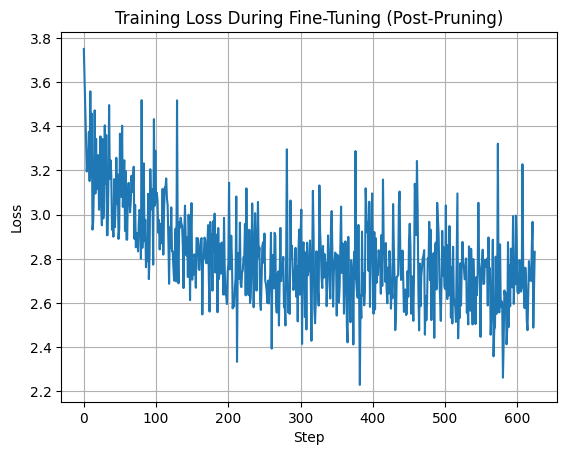

In [12]:
import matplotlib.pyplot as plt

plt.plot(epoch_losses)
plt.title("Training Loss During Fine-Tuning (Post-Pruning)")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [13]:


###############################################################################
# 5) POST-PROCESSING & EVALUATION
###############################################################################
# We'll do a naive approach: take argmax of start/end, decode, compare with ground truth.
val_contexts = val_data["context"]
val_questions = val_data["question"]
val_answers = val_data["answers"]  # list of dicts with "text", "answer_start"

def normalize_text(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    def remove_articles(txt):
        return re.sub(r"\b(a|an|the)\b", " ", txt)
    def remove_punc(txt):
        return "".join(ch for ch in txt if ch not in string.punctuation)

    s = s.lower()
    s = remove_articles(s)
    s = remove_punc(s)
    s = " ".join(s.split())
    return s

def compute_exact_match(pred, truth):
    return int(normalize_text(pred) == normalize_text(truth))

def compute_f1(pred, truth):
    pred_tokens = normalize_text(pred).split()
    truth_tokens = normalize_text(truth).split()
    common = set(pred_tokens) & set(truth_tokens)
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)
    if len(common) == 0:
        return 0
    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(truth_tokens)
    if precision + recall == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)

student_model.eval()
em_scores = []
f1_scores = []

val_dataloader = DataLoader(val_tds, batch_size=8, shuffle=False)
offset = 0  # to track the global index in val_data
with torch.no_grad():
    for batch in val_dataloader:
        if len(batch) == 5:
            input_ids, attention_mask, token_type_ids, start_pos, end_pos = batch
            token_type_ids = token_type_ids.to(DEVICE)
        else:
            input_ids, attention_mask, start_pos, end_pos = batch
            token_type_ids = None

        input_ids = input_ids.to(DEVICE)
        attention_mask = attention_mask.to(DEVICE)

        outputs = student_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        start_logits = outputs.start_logits
        end_logits   = outputs.end_logits

        start_indices = torch.argmax(start_logits, dim=1).cpu().numpy()
        end_indices   = torch.argmax(end_logits,   dim=1).cpu().numpy()

        for i in range(len(start_indices)):
            global_idx = offset + i
            if global_idx >= len(val_contexts):
                continue

            s_ind = start_indices[i]
            e_ind = end_indices[i]
            if e_ind < s_ind:
                e_ind = s_ind

            # Decode predicted tokens
            tokens_ = input_ids[i][s_ind : e_ind+1].cpu().numpy().tolist()
            pred_text = tokenizer.decode(tokens_, skip_special_tokens=True)

            # Ground truth: we pick the first answer
            gold_answers = val_answers[global_idx]["text"]
            if len(gold_answers) > 0:
                gold_answer = gold_answers[0]
            else:
                gold_answer = ""

            em = compute_exact_match(pred_text, gold_answer)
            f1 = compute_f1(pred_text, gold_answer)

            em_scores.append(em)
            f1_scores.append(f1)

        offset += len(start_indices)

avg_em = np.mean(em_scores) * 100
avg_f1 = np.mean(f1_scores) * 100
print(f"  Exact Match: {avg_em:.2f}%")
print(f"  F1 Score:    {avg_f1:.2f}%")




Validation Results (subset of 1000 samples):
  Exact Match: 1.30%
  F1 Score:    5.30%


In [14]:
import torch

def ask_question(question: str, context: str, model, tokenizer, device="cpu"):
    """
    Given a question and a context, use the provided model to
    predict the answer span and return the decoded string answer.
    """
    # 1) Encode inputs
    inputs = tokenizer(question, context, return_tensors="pt", truncation=True)
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    token_type_ids = None
    if "token_type_ids" in inputs:
        token_type_ids = inputs["token_type_ids"].to(device)

    # 2) Forward pass
    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
    start_logits = outputs.start_logits
    end_logits = outputs.end_logits

    # 3) Get predicted start/end token indices
    start_index = torch.argmax(start_logits, dim=1).item()
    end_index = torch.argmax(end_logits, dim=1).item()

    # Ensure the end_index is >= start_index
    if end_index < start_index:
        end_index = start_index

    # 4) Decode tokens back to string
    answer_ids = input_ids[0, start_index : end_index+1]
    answer_text = tokenizer.decode(answer_ids, skip_special_tokens=True)

    return answer_text

In [15]:
# -------------------------------------------------
# Final demonstration: Validate student model works
# -------------------------------------------------

question = "Which city is Galatasaray based in?"
context = "Galatasaray, is a Turkish professional football club based on the European side of the city of Istanbul. It is founded in 1905. The team traditionally play in dark shades of red and yellow at home."

# Evaluate with teacher model
teacher_model.eval()
teacher_answer = ask_question(question, context, teacher_model, tokenizer, device="cuda")
print(f"[Teacher Answer]: {teacher_answer}")

# Evaluate with student model
student_model.eval()
student_answer = ask_question(question, context, student_model, tokenizer, device="cuda")
print(f"[Student Answer]: {student_answer}")





[Teacher Answer]: istanbul
[Student Answer]: shades


In [16]:
teacher_model.eval()
student_model.eval()

sample_question = "Who wrote the novel 1984?"
sample_context = (
    "George Orwell was a British author best known for his novels Animal Farm and 1984. "
    "He was a critic of totalitarianism and wrote extensively about political issues."
)

student_answer = ask_question(sample_question, sample_context, student_model, tokenizer, device=DEVICE)
teacher_answer = ask_question(sample_question, sample_context, teacher_model, tokenizer, device=DEVICE)

print(f"Question: {sample_question}")
print(f"Student Answer: {student_answer}")
print(f"Teacher Answer: {teacher_answer}")


Question: Who wrote the novel 1984?
Student Answer: george orwell
Teacher Answer: george orwell


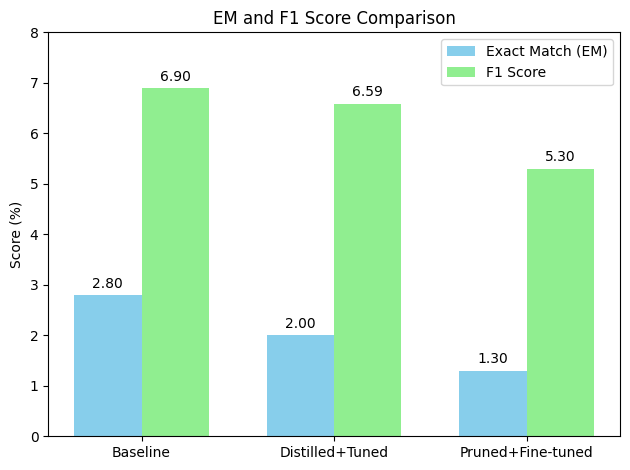

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# EM and F1 values from your experiments
labels = ["Baseline", "Distilled+Tuned", "Pruned+Fine-tuned"]
em_scores = [2.8, 2.0, 1.3]
f1_scores = [6.9, 6.59, 5.3]

x = np.arange(len(labels))  # label locations
width = 0.35  # bar width

# Create plot
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, em_scores, width, label='Exact Match (EM)', color='skyblue')
rects2 = ax.bar(x + width/2, f1_scores, width, label='F1 Score', color='lightgreen')

# Add text labels
ax.set_ylabel('Score (%)')
ax.set_title('EM and F1 Score Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 8)
ax.legend()

# Optional: Add value labels on top of bars
def add_labels(rects):
    for r in rects:
        height = r.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(r.get_x() + r.get_width() / 2, height),
                    xytext=(0, 3),  # offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()
